In [22]:
from functions import *
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_smooth,
    labs, xlab, element_blank
)

In [5]:
data_ml = load_data()

<Axes: >

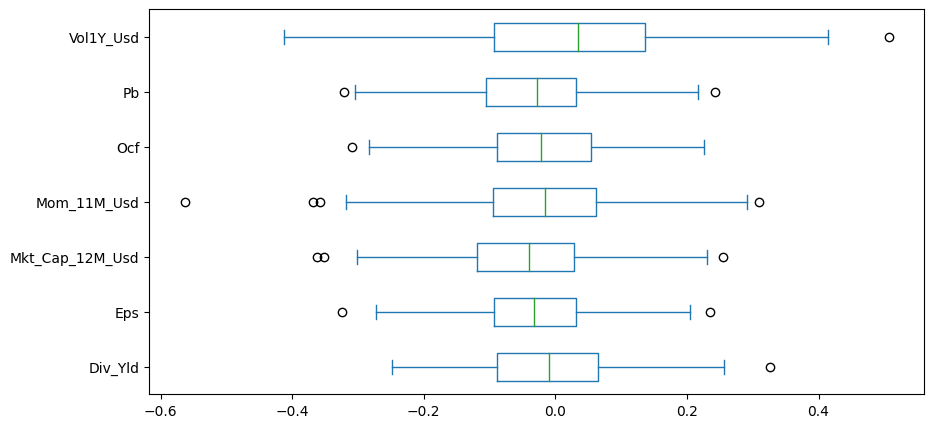

In [6]:
# use boxplot to exam summary statistics
# here we check the correlation between features and return
df = data_ml.loc[:,["date","R1M_Usd"]+features_short]
df.groupby("date").apply(lambda df: df[features_short].corrwith(df["R1M_Usd"])).plot(kind="box", vert=False)

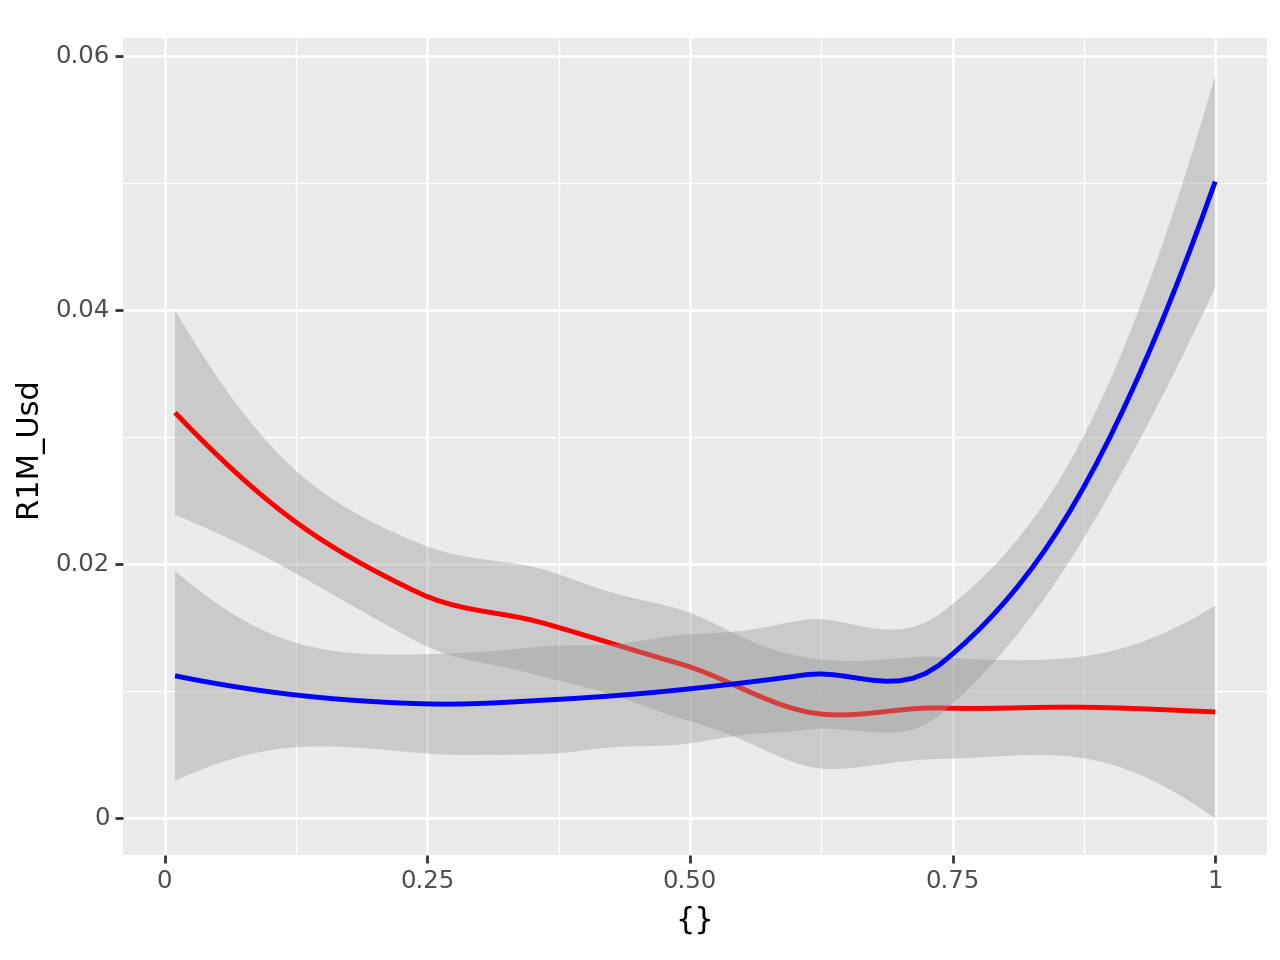

<Figure Size: (640 x 480)>

In [25]:
# the correlation between the predictors and the return can also be seen by ploting the conditional average E(Y|X=x)
# it's too slow to run the full data set on my comuputer so I just take 10% randomly
reduced_data = data_ml.iloc[np.random.choice(data_ml.shape[0], 20000),:]
(ggplot(reduced_data, aes(y='R1M_Usd')) + geom_smooth(aes(x="Mkt_Cap_12M_Usd"), method="loess", color="red") 
+ geom_smooth(aes(x="Vol1Y_Usd"), method="loess", color="blue") + labs(color="Predictor") +xlab(element_blank())
                                                                                                )
# didn't figure out how to add

In [30]:
#exam the autocorrelations of each feature
features = data_ml.columns.to_list()[3:95]
df = data_ml.loc[:,["stock_id"]+features]

In [35]:
def acf(x, leg=1):
    return np.corrcoef(x[:-leg], x[leg:])[0,1]

acfs = df.groupby("stock_id").aggregate(acf).values.flatten()

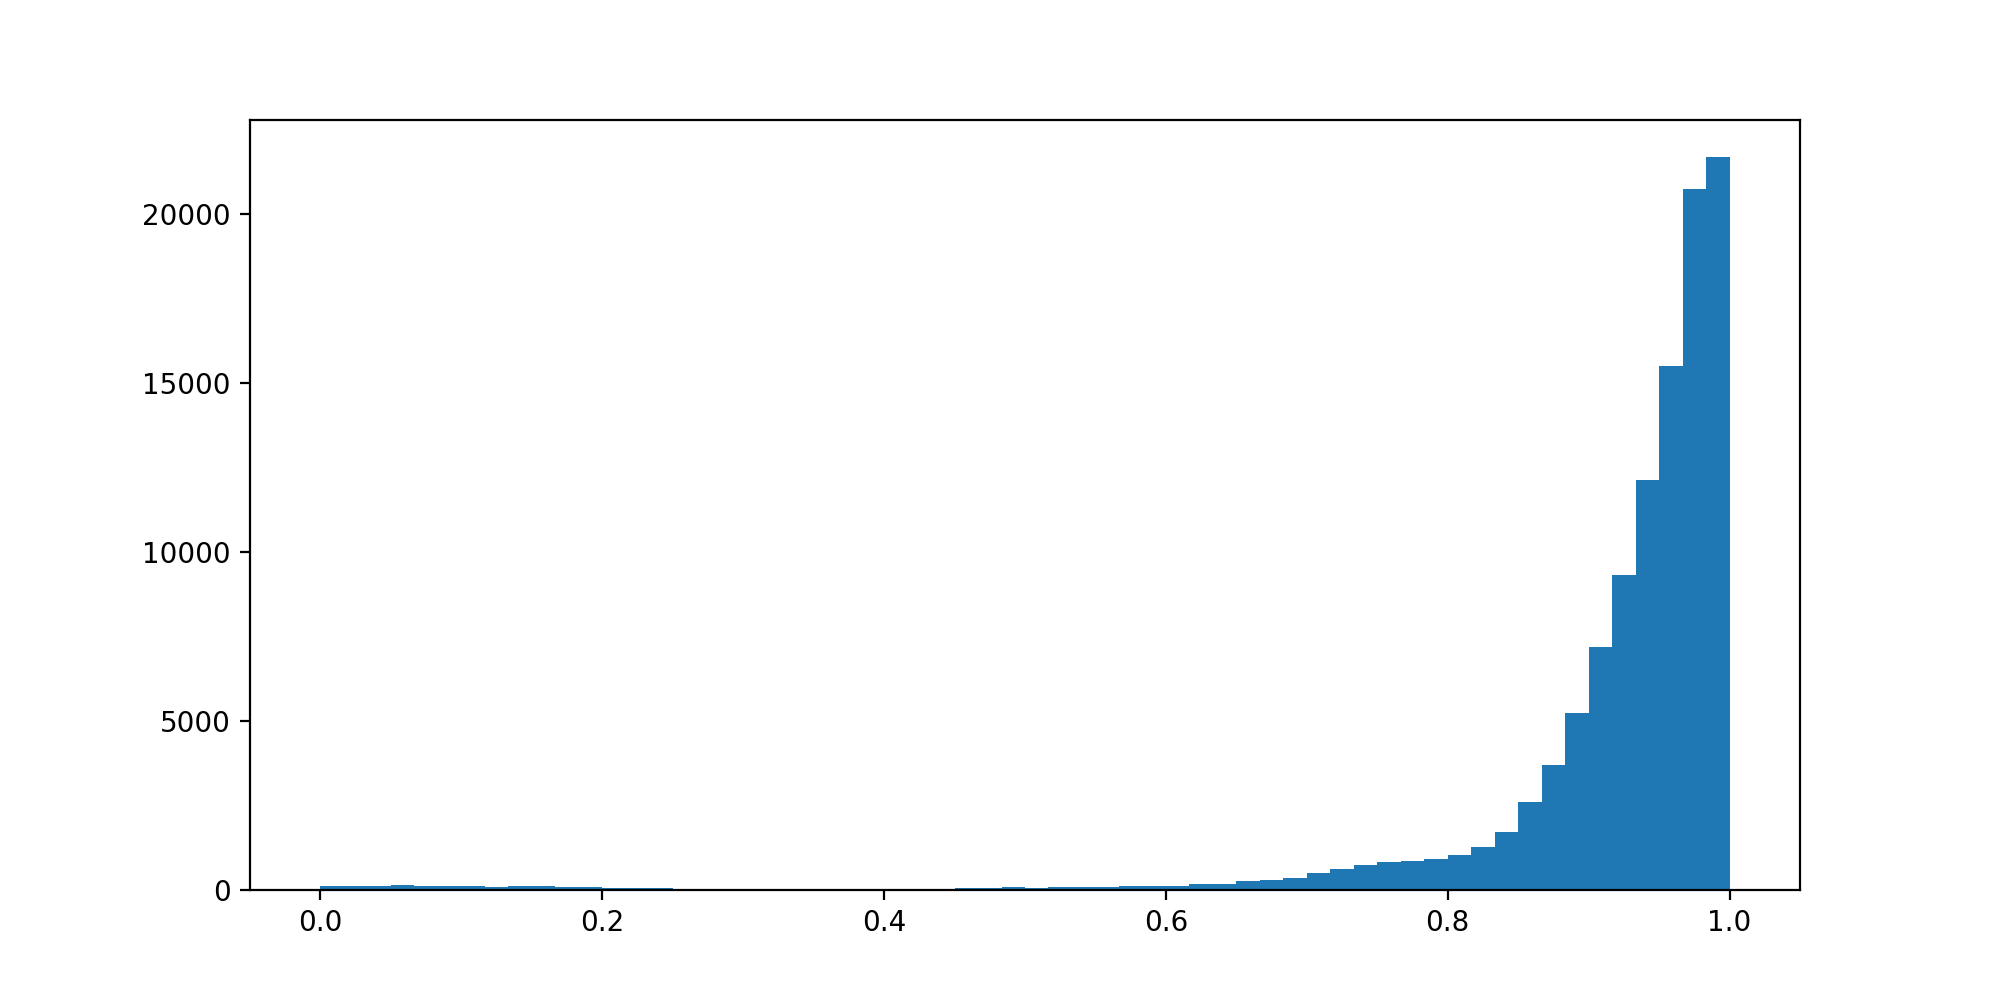

In [44]:
ax = plt.hist(acfs, bins=60, range=(0,1))